Tasas implicitas Futuros

In [8]:
import requests
import pandas as pd

# API endpoint
url = "https://apicem.matbarofex.com.ar/api/v2/closing-prices"

# Query parameters
params = {
    "product": "DLR",
    "segment": "Monedas",
    "type": "FUT",
    "excludeEmptyVol": "true",
    "from": "2025-09-02",
    "to": "2025-10-10",
    #"page": "1",
    "pageSize": "500",
    "sortDir": "ASC",
    "market": "ROFX"
}

# Send GET request
response = requests.get(url, params=params)

# Check if request was successful
if response.status_code == 200:
    data = response.json()
    
    # Often APIs return data under a key like "content" or "results"
    # If so, replace 'data' below with data["content"]
    try:
        df = pd.DataFrame(data['data'])
    except ValueError:
        df = pd.json_normalize(data['data'])
    
    print(df.head())
else:
    print(f"Request failed with status code {response.status_code}")
    print(response.text)



# BYMA DATA API
url_simul = 'https://new2.bymadata.com.ar/vanoms-be-core/rest/api/byma/data/quantex/trades-volumes'
payload = '{"layout_oid":4375,"page_number":1,"Content-Type":"application/json"}'


                   dateTime     symbol  settlement    high     low    open  \
0  2025-09-02T00:00:00.000Z  DLR092025      1406.0  1421.0  1397.0  1416.5   
1  2025-09-02T00:00:00.000Z  DLR102025      1468.5  1480.0  1453.0  1479.0   
2  2025-09-02T00:00:00.000Z  DLR112025      1509.0  1513.0  1491.0  1512.0   
3  2025-09-02T00:00:00.000Z  DLR122025      1542.0  1548.0  1518.5  1538.0   
4  2025-09-02T00:00:00.000Z  DLR012026      1574.0  1579.0  1548.5  1573.5   

    close  openInterest  openInterestChange  change  ...  tradeCount  \
0  1407.0     1895120.0            -52429.0   -13.0  ...        5730   
1  1468.5      680438.0             36729.0   -12.0  ...        1161   
2  1509.5      526430.0              5856.0    -5.0  ...         265   
3  1540.5     1349296.0             13577.0    -3.5  ...         595   
4  1577.0      341878.0             -5735.0     0.0  ...         138   

   impliedRate  previousClose  unitsOpenInterest  unitsOpenInterestChange  \
0      35.9655       

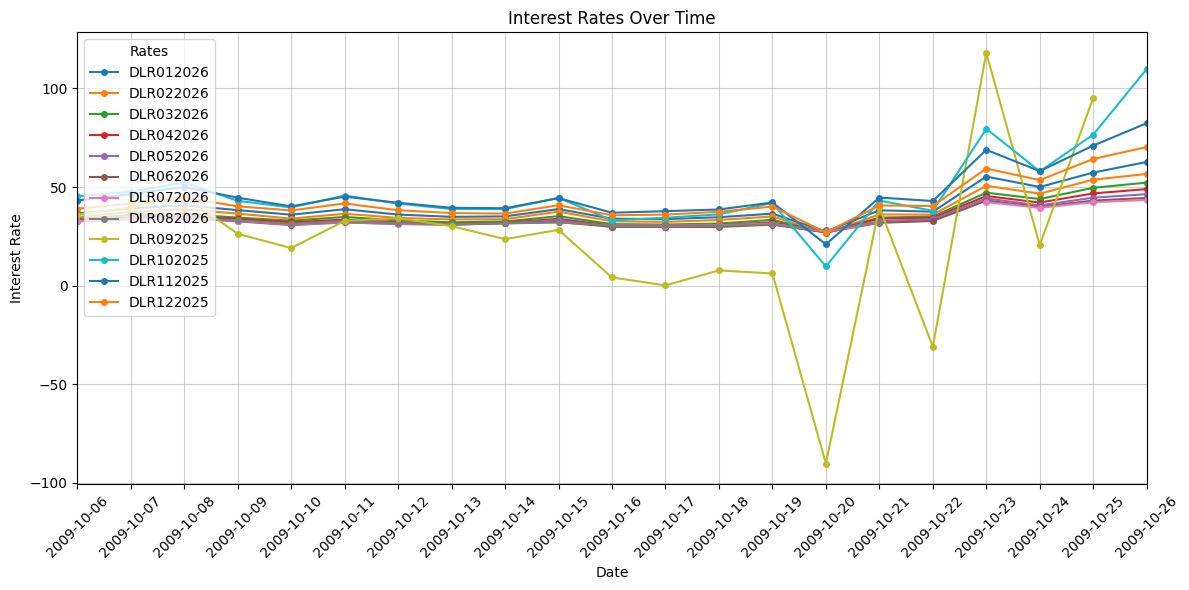

In [71]:

rates = df.pivot(index='dateTime',columns='symbol',values=['impliedRate'])
rates.columns = rates.columns.droplevel(0)  # Drop the top level of the MultiIndex
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import numpy as np

def plot_futures(data=rates, kind='line', ylabel="Interest Rate", title="Interest Rates Over Time", legend_name = "Rates"):
    # Ensure index is datetime
    def human_format(num):
        if num >= 1_000_000_000:
            return f"{num/1_000_000_000:.1f}B"
        elif num >= 1_000_000:
            return f"{num/1_000_000:.1f}M"
        elif num >= 1_000:
            return f"{num/1_000:.1f}k"
        else:
            return str(int(num))
    
    data.index = pd.to_datetime(data.index)

    # Plot all columns
    if kind == 'line':
        ax = data.plot(figsize=(12, 6), kind=kind, marker='o', markersize=4)
    elif kind == 'bar':
        ax = data.plot(figsize=(12, 6), kind=kind, stacked=True, width=0.95)
        ax.yaxis.set_major_formatter(mticker.FuncFormatter(
            lambda x, _: f"{x/1000:.0f}k" if x >= 1000 else f"{int(x)}"
        ))
        
        for container in ax.containers:
            ax.bar_label(container, labels=[human_format(v.get_height()) if v.get_height() > 0 else "" 
                                    for v in container], 
                 label_type="center", fontsize=8, color="black")
        # bottom = np.zeros(len(data.index))
        # bars = []

        # # Plot stacked bars and keep references
        # for col in data.columns:
        #     bar = ax.bar(data.index, data[col], bottom=bottom, label=col, width=2)
        #     bars.append((bar, col, bottom.copy()))  # save for labeling
        #     bottom += data[col].fillna(0).values

        # # Add data labels for each bar segment
        # for bar, col, base in bars:
        #     for rect, value, y0 in zip(bar, data[col].fillna(0).values, base):
        #         if value > 0:  # skip labels for zero
        #             ax.text(
        #                 rect.get_x() + rect.get_width() / 2,   # center of bar
        #                 y0 + value / 2,                       # middle of segment
        #                 f"{int(value)}",                      # label
        #                 ha="center", va="center", fontsize=8, color="white"
        #             )

    # Format x-axis: show date every 5 days
    #ax.xaxis.set_ticks(data.index)
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

    # Rotate labels for readability
    plt.xticks(rotation=45)

    # Add labels and title
    plt.xlabel("Date")
    plt.ylabel(ylabel)
    plt.title(title)

    # Add legend
    plt.legend(title=legend_name, loc="upper left")

    # Add grid
    plt.grid(True, linestyle="-", alpha=0.6)

    plt.tight_layout()
    plt.show()

plot_futures()

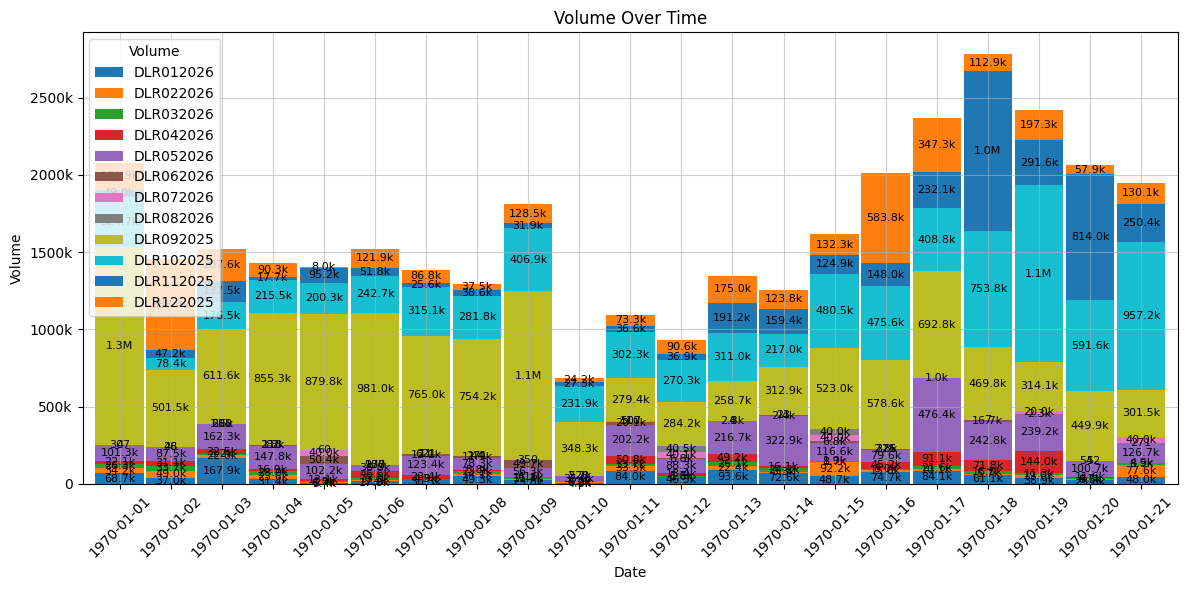

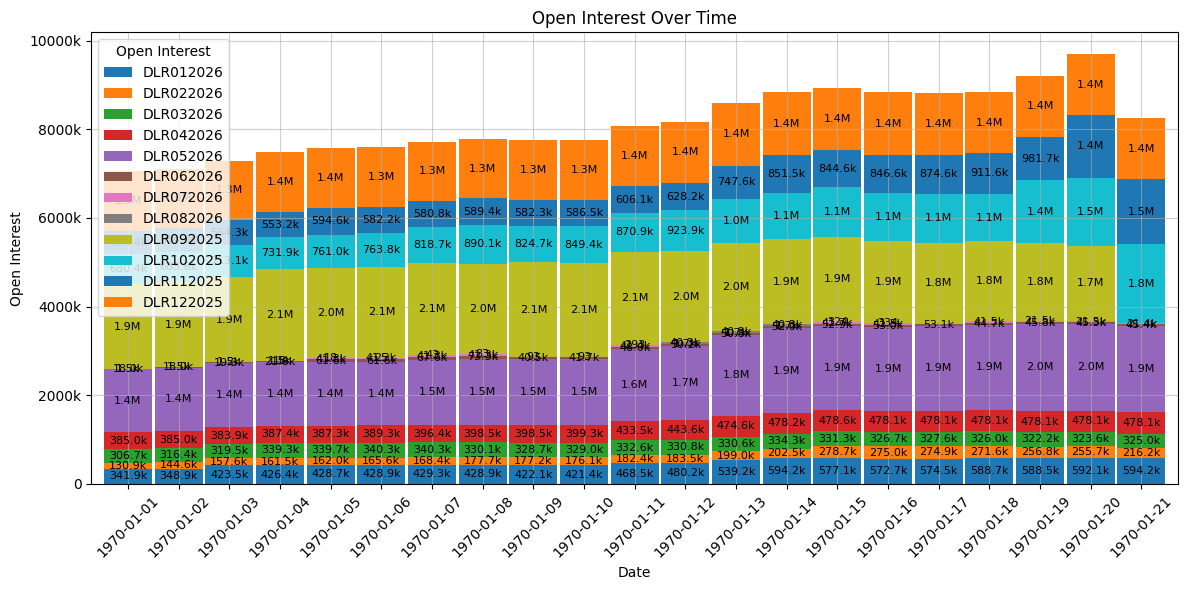

In [72]:
volume = df.pivot(index='dateTime',columns='symbol',values=['volume'])
volume.columns = volume.columns.droplevel(0)  # Drop the top level of the MultiIndex

openInterest = df.pivot(index='dateTime',columns='symbol',values=['openInterest'])
openInterest.columns = openInterest.columns.droplevel(0)  # Drop the top level of the MultiIndex

plot_futures(data=volume, kind='bar', ylabel="Volume", title="Volume Over Time", legend_name = "Volume")
plot_futures(data=openInterest, kind='bar', ylabel="Open Interest", title="Open Interest Over Time", legend_name = "Open Interest")